# 1D Quantum Mechanics Monte Carlo integration exercises:

Goals broady taken from exercise 2: 

Write a computer program to implement the Metropolis Monte Carlo algorithm for a one dimensional quantum mechanical system with some potential, e.g., a harmonic oscillator, and calculate a two-point correlation function, most frequently used:

$$ G(t) = \frac{1}{N}\sum_{j}\langle\langle x(t_j + t)x(t_j)\rangle\rangle $$

for all $t = 0,a,2a,\dots,(N-1)a$; that is calculate

$$ G_n = \frac{1}{N}\sum_{j}\langle\langle x_{(j+n)\text{mod}N}x_j\rangle\rangle$$

for $n=0,\dots,N-1$, The $(j+n)\text{mod}N$ in this last expression reflects the periodic boundary conditions.

Use the results to compute the excitation energy from 

$$ \Delta E_n \coloneqq \log(G_n/G_{n+1}) \xrightarrow[]{n\text{ large}} (E_1 - E_0)a. $$

## Exercise-generic code:

Let us start with some packages that will be used:

In [5]:
begin
    using DelimitedFiles
    using Distributions: Uniform
    using SpecialFunctions
    using LaTeXStrings
    using LinearAlgebra
    using Match
    using Plots
    using Random
    using Test 
end

A simple @match (cf. switch) for selecting on which local action we are using in the Params constructor.

In [6]:
function matchaction(action::Integer)
    return @match action begin
        0 => S_HO
        1 => S_HOimproved
        2 => S_AHO
        3 => S_AHOimproved
        4 => S_HOtrick
        5 => S_AHOtrick
    end
end

matchaction (generic function with 1 method)

Instead of global variables, let's store our parameters in a struct so that we can easily modify them, such as special, simple sets for testing.

In [7]:
const ACTION_HO = 0; # Harmonic oscillator acticon
const ACTION_HO_IMPROVED = 1; # Harmonic oscillator action improved with corrected approximation, Eq. (50).
const ACTION_AHO = 2; # Anharmonic oscillator action
const ACTION_AHO_IMPROVED = 3; # Anharmonic oscillator action improved with corrected approximation, Eq. (50).
const ACTION_HO_TRICK = 4;
const ACTION_AHO_TRICK = 5;

The Params type is constructed by passing which action to use as a Integer (to be read easily from, e.g., a parameter file), and is used to set the $S$ member as an actual first-class function to be called later, in update!().

In [8]:
#struct Params{T<:AbstractFloat,S<:Integer}
#    a::T # Lattice spacing
#    ϵ::T # Uniform distribution range
 #   N::S # Number of sites
#    N_cor::S # Number of steps to de-correlate random paths
#    N_cf::S # Number of configurations (random paths)
#    action::S # Which action are we using.
#end
struct Params{T<:AbstractFloat, Q<:Integer}
    a::T
    ϵ::T
	N::Q
	N_cor::Q
	N_cf::Q
	S::Function
    function Params(a_::A, ϵ_::A, N_::B, N_cor_::B, N_cf_::B, action::B) where {A<: AbstractFloat, B<:Integer}
        S_ = matchaction(action)
		return new{A,B}(a_, ϵ_, N_, N_cor_, N_cf_, S_)
    end
end

The $S(j,x,\text{params})$ function returns the $x_j$-dependant values of the action. This is for the harmonic oscillator. It takes the index of interest and the lattice, as well as the parameters, and it returns the calculated value. We also have the potential $V(x)=x^2(1+2x^2)/2$ as an example anharmonic oscillator.

In [9]:
function S_HO(j::Integer, x::AbstractVector, params::Params)
    #j_next = j%params.N + 1; # Find the next
    #j_prev = (j+params.N-2)%params.N + 1; # and previous site locations
    j_next = mod1(j+1,params.N)
    j_prev = mod1(j-1,params.N)
    # Return the local value of the action for the HO with x_0 = x_N = x
    return params.a*x[j]^2/2 + x[j]*(x[j]-x[j_prev]-x[j_next])/params.a
end
function S_AHO(j::Integer, x::AbstractVector, params::Params)
    #j_next = j%params.N + 1; # Find the next
    #j_prev = (j+params.N-2)%params.N + 1; # and previous site locations
    j_next = mod1(j+1,params.N)
    j_prev = mod1(j-1,params.N)
    # Return the local value of the action for the HO with x_0 = x_N = x
    return params.a*x[j]^2*(1 + 2*x[j]^2)/2 + x[j]*(x[j]-x[j_prev]-x[j_next])/params.a
end

S_AHO (generic function with 1 method)

In [10]:
@testset "Local action (S) tests" begin
    a = 0.5
    N = 3
    ϵ = 1.4
    N_cor  = 20
    N_cf = 1000
    action = ACTION_HO
    params = Params(a,ϵ,N,N_cor,N_cf, action)
    x = [j for j in 1:N] #Fake, easily checkable path
    # Check first site, x[1] = 1, x[1+1] = 2, x[1-1] = N
    @test S_HO(1,x,params) == a*(1)^2/2 + (1)*((1)-(N)-(2))/a 
    # Check last site, x[N] = N, x[N+1] = 1, x[N-1] = N-1
    @test S_HO(N,x,params) == a*(N)^2/2 + (N)*((N)-(1)-(N-1))/a 
    # Check some middle site , x[j] = j, x[j+1] = j+1, x[j-1] = j-1
    for j in 2:N-1
        @test S_HO(j,x,params) == a*(j)^2/2 + (j)*((j)-(j+1)-(j-1))/a
    end  
    @test S_AHO(1,x,params) == a*(1)^2*(1+2*1^2)/2 + (1)*((1)-(N)-(2))/a 
    # Check last site, x[N] = N, x[N+1] = 1, x[N-1] = N-1
    @test S_AHO(N,x,params) == a*(N)^2*(1+2*N^2)/2 + (N)*((N)-(1)-(N-1))/a 
    # Check some middle site , x[j] = j, x[j+1] = j+1, x[j-1] = j-1
    for j in 2:N-1
        @test S_AHO(j,x,params) == a*(j)^2*(1+2*j^2)/2 + (j)*((j)-(j+1)-(j-1))/a
    end    
end

Test Summary:          | Pass  Total
Local action (S) tests |    6      6


Test.DefaultTestSet("Local action (S) tests", Any[], 6, false, false)

Using the corrected approximation, Eq. (50), for the second derivative, we have the improved action 

$$ S_\text{imp}[x] \coloneqq \sum_{j=0}^{N-1}a\bigg( -\frac{1}{2}mx_j \big( \triangle^{(2)} - a^2(\triangle^{(2)}/12) \big)x_j + aV(x_j) \bigg), $$

which yields the local action with contributions from five terms in the above sum:

- $(j)$ th term: $ -\frac{m}{24a}x_j \big( -x_{j+2} + 16x_{j+1} - 30 x_j + 16 x_{j-1} -x_{j-2}\big) + aV(x_j) $;
- $(j+1)$ th term: $ -\frac{m}{24a}x_{j+1} \big( -x_{j+3} + 16x_{j+2} - 30 x_{j+1} + 16 x_{j} -x_{j-1}\big) + aV(x_{j+1}) $;
- $(j+2)$ th term: $ -\frac{m}{24a}x_{j+2} \big( -x_{j+4} + 16x_{j+3} - 30 x_{j+2} + 16 x_{j+1} -x_{j}\big) + aV(x_{j+2}) $;
- $(j-1)$ th term: $ -\frac{m}{24a}x_{j-1} \big( -x_{j+1} + 16x_{j} - 30 x_{j-1} + 16 x_{j-2} -x_{j-3}\big) + aV(x_{j-1}) $;
- $(j-2)$ th term: $ -\frac{m}{24a}x_{j-2} \big( -x_{j} + 16x_{j-1} - 30 x_{j-2} + 16 x_{j-3} -x_{j-4}\big) + aV(x_{j-2}) $,

of which we can throw away values not depending on $x_j$ to determine the local action as 

$$ S_\text{imp}^j[x] = -\frac{m}{24a}x_j \big( -x_{j+2} + 16x_{j+1} - 30 x_j + 16 x_{j-1} -x_{j-2}\big) + aV(x_j) -\frac{16m}{24a}x_{j+1}x_j + \frac{m}{24a}x_{j+2}x_j -\frac{16m}{24a}x_{j-1}x_j + \frac{m}{24a}x_{j-2}x_j. $$

Simplifying

$$ S_\text{imp}^j[x] = -\frac{m}{24a}x_j \big( -2x_{j+2} + 32x_{j+1} - 30 x_j + 32 x_{j-1} -2x_{j-2}\big) + aV(x_j) = \frac{m}{12a}x_j \big( x_{j+2} - 16x_{j+1} + 15 x_j - 16 x_{j-1} +x_{j-2}\big) + aV(x_j)$$

In [11]:
function S_HOimproved(j::Integer, x::AbstractVector, params::Params)
    #j_next = j%params.N + 1; # Find the next
    #j_prev = (j+params.N-2)%params.N + 1; # and previous site locations
    j_next = mod1(j+1,params.N)
    j_prev = mod1(j-1,params.N)
    j_2next = mod1(j+2,params.N)
    j_2prev = mod1(j-2,params.N)
    # Return the local value of the action for the HO with x_0 = x_N = x
    return params.a*x[j]^2/2 + x[j]*(15*x[j]-16*x[j_prev]-16*x[j_next]+x[j_2prev]+x[j_2next])/(12*params.a)
end

function S_AHOimproved(j::Integer, x::AbstractVector, params::Params)
    #j_next = j%params.N + 1; # Find the next
    #j_prev = (j+params.N-2)%params.N + 1; # and previous site locations
    j_next = mod1(j+1,params.N)
    j_prev = mod1(j-1,params.N)
    j_2next = mod1(j+2,params.N)
    j_2prev = mod1(j-2,params.N)
    # Return the local value of the action for the HO with x_0 = x_N = x
    return params.a*x[j]^2*(1+2*x[j]^2)/2 + x[j]*(15*x[j]-16*x[j_prev]-16*x[j_next]+x[j_2prev]+x[j_2next])/(12*params.a)
end

S_AHOimproved (generic function with 1 method)

In [12]:
@testset "Local action (S_imp) tests" begin
    a = 0.5
    N = 50
    ϵ = 1.4
    N_cor  = 20
    N_cf = 1000
    action = ACTION_HO_IMPROVED
    params = Params(a,ϵ,N,N_cor,N_cf, action)
    x = [j for j in 1:N] #Fake, easily checkable path
    # Check first site, x[1] = 1, x[1+1] = 2, x[1-1] = N
    @test S_HOimproved(1,x,params) == a*((1^2)/2) + 1*(15*1-16*N-16*2+(N-1)+3)/(12*a)
    # Check second site, x[1] = 1, x[1+1] = 2, x[1-1] = N
    @test S_HOimproved(2,x,params) == a*((2^2)/2) + 2*(15*2-16*1-16*3+(N)+4)/(12*a)
    # Check last site, x[N] = N, x[N+1] = 1, x[N-1] = N-1
    @test S_HOimproved(N,x,params) == a*N^2/2 + N*(15*N-16*(N-1)-16*1+(N-2)+2)/(12*a)
    # Check last site, x[N] = N, x[N+1] = 1, x[N-1] = N-1
    @test S_HOimproved(N-1,x,params) == a*(N-1)^2/2 + (N-1)*(15*(N-1)-16*(N)-16*(N-2)+(1)+(N-3))/(12*a)
    # Check some middle site , x[j] = j, x[j+1] = j+1, x[j-1] = j-1
    for j in 3:N-2
        @test S_HOimproved(j,x,params) == a*j^2/2 + j*(15*j-16*(j-1)-16*(j+1)+j-2+j+2)/(12*a)
    end    
end

Test Summary:              | Pass  Total
Local action (S_imp) tests |   50     50


Test.DefaultTestSet("Local action (S_imp) tests", Any[], 50, false, false)

In [13]:
function S_HOtrick(j::Integer, x::AbstractVector, params::Params)
    #j_next = j%params.N + 1; # Find the next
    #j_prev = (j+params.N-2)%params.N + 1; # and previous site locations
    j_next = mod1(j+1,params.N)
    j_prev = mod1(j-1,params.N)
    # Return the local value of the action for the HO with x_0 = x_N = x
    return params.a*x[j]^2*(1+params.a^2/12)/2 + x[j]*(x[j]-x[j_prev]-x[j_next])/params.a
end
function S_AHOtrick(j::Integer, x::AbstractVector, params::Params)
    c = 2.0
    #j_next = j%params.N + 1; # Find the next
    #j_prev = (j+params.N-2)%params.N + 1; # and previous site locations
    j_next = mod1(j+1,params.N)
    j_prev = mod1(j-1,params.N)
    # Return the local value of the action for the HO with x_0 = x_N = x
    x_j = x[j]
    a = params.a
    V = x_j^2*(1 + c*x_j^2)/2 + a^2*(x_j+2*c*x_j^3)^2/24 - a*c*x_j^2/4+a^3*(c*x_j^2/4)^2/2
    return a*V + x[j]*(x[j]-x[j_prev]-x[j_next])/a
end

S_AHOtrick (generic function with 1 method)

Need all of the various actions defined to test.

In [14]:
@testset "matchaction test" begin
    @test matchaction(ACTION_HO) == S_HO
    @test matchaction(ACTION_HO_IMPROVED) == S_HOimproved
    @test matchaction(ACTION_AHO) == S_AHO
    @test matchaction(ACTION_AHO_IMPROVED) == S_AHOimproved
    @test matchaction(ACTION_HO_TRICK) == S_HOtrick
    @test matchaction(ACTION_AHO_TRICK) == S_AHOtrick
end

Test Summary:    | Pass  Total
matchaction test |    6      6


Test.DefaultTestSet("matchaction test", Any[], 6, false, false)

The update!(x,params) function performs one Metropolis update of the path $x[j]$. It takes the path to be update and the params, and returns nothing as it updates the path in-place.

In [15]:
function update!(x::AbstractVector, params::Params)
    #S = matchaction(params.action)
    for j in eachindex(x)
        ζ = rand(Uniform(-params.ϵ,params.ϵ))
        x_old = x[j]   # Save original path value
        S_old = params.S(j,x,params) # and original local action value
        x[j] += ζ # Update path
        ΔS = params.S(j,x,params) - S_old # Change in the action
        if ΔS > 0 && exp(-ΔS) < rand()
            x[j] = x_old # Restore old path value; should happen less than acceptance
        end
    end
    return nothing;
end

update! (generic function with 1 method)

This is a deterministic version of update!, taking the normally randomly generated parameters instead as arguments, for the purposes of testing. Clealy it only makes sense for a lattice of length 1, but that is sufficient for logic testing.

TODO: Is there a better was to test update! without a code copy.

In [16]:
function test_update!(x::AbstractVector, params::Params, ζ::AbstractFloat, 
        η::AbstractFloat)
    #S = matchaction(params.action)
    for j in eachindex(x)
        x_old = x[j]
        S_old = params.S(j,x,params)
        x[j] += ζ
        ΔS = params.S(j,x,params) - S_old
        if ΔS > 0 && exp(-ΔS) < η
            x[j] = x_old # Restore old path value; should happen less than acceptance
        end
    end
    return nothing
end

test_update! (generic function with 1 method)

In [17]:
@testset "update tests" begin
    a = 0.5
    N = 1 # This is just for testing the acceptance/rejection logic
    ϵ = 1.4
    N_cor  = 20
    N_cf = 1000
    action = ACTION_HO_IMPROVED
    params = Params(a,ϵ,N,N_cor,N_cf,action)

    x = ones(N) # Fake path
    ζ = 0.1; η = 0.75 # Fake update that yields ΔS < 0, and so should return a different path 
    test_update!(x,params,ζ,η)
    @test x[N] == 1 + ζ
    
    x = ones(N) # Reset fake path
    ζ = -0.1; η = 0.1 # Fake update that yields ΔS > 0, and so should return a different path 
    test_update!(x,params,ζ,η)
    @test x[N] == 1 + ζ
    
    x = ones(N) # Reset fake path
    ζ = -0.1; η = 0.8 # Fake update that yields ΔS > 0 (but exp(-ΔS) ≈ 0.7), and should return the same path  
    test_update!(x,params,ζ,η)
    @test x[N] == 1
end

Test Summary: | Pass  Total
update tests  |    3      3


Test.DefaultTestSet("update tests", Any[], 3, false, false)

The function $G(x,n,params)$ is the function $G(t)$ for some path $x[j]$ at some time $t=n$. It calculates and returns 

$$ G_n = \frac{1}{N}\sum\nolimits_{j=0}^{N-1}\langle\langle x_{(j+n)\text{mod}N} x_j \rangle\rangle = \frac{1}{N}\sum\nolimits_{j=1}^{N}\langle\langle x_{(j+n)\text{mod}_1N} x_j \rangle\rangle, $$

where the last equality is by the periodicity, and is more natural for our 1-based indexing. Similarly, the the function:
$$ G_n^3 = \frac{1}{N}\sum\nolimits_{j=0}^{N-1}\langle\langle x_{(j+n)\text{mod}N}^3 x_j^3 \rangle\rangle = \frac{1}{N}\sum\nolimits_{j=1}^{N}\langle\langle x_{(j+n)\text{mod}_1N}^3 x_j^3 \rangle\rangle, $$

used in exercise 3. TODO: Maybe a better name?

Big note is that since $G(t)$ is to be evaluated for all $t=0,a,2a\dots(N-1)a$, which would be $G_n$ for $n=0\dots N-1$, but since we have 1-indexing, then we actual need to calculate $G_{n-1}$, for $n=1\dots N$ for the correct shifting to occur.

In [18]:
function G(x::AbstractVector, n::Integer ,params::Params)
    g = 0.0
    for j in eachindex(x)
        #j_next = ((j+n-1)%N) + 1
        j_next = mod1(j+n-1,params.N) # Account for temporal shift in n as an index
        g += x[j]*x[j_next]
    end
    return g/params.N
end

function G3(x::AbstractVector, n::Integer ,params::Params)
    g = 0.0
    for j in eachindex(x)
        j_next = mod1(j+n-1,params.N)
        g += x[j]^3*x[j_next]^3
    end
    return g/params.N
end

G3 (generic function with 1 method)

In [19]:
@testset "G(t) tests" begin
    a = 0.5
    N = 3
    ϵ = 1.4
    N_cor  = 20
    N_cf = 1000
    action = ACTION_HO
    params = Params(a,ϵ,N,N_cor,N_cf, action)
    x = [j for j in 1:N]
    n = 3
    @test G(x,n,params) == (1*2 + 2*3 + 3*1)/3
    n = 2
    @test G(x,n,params) == (1*3 + 2*1 + 3*2)/3
    n = 1
    @test G(x,n,params) == (1*1 + 2*2 + 3*3)/3
end

@testset "G3(t) tests" begin
    a = 0.5
    N = 3
    ϵ = 1.4
    N_cor  = 20
    N_cf = 1000
    action = ACTION_HO
    params = Params(a,ϵ,N,N_cor,N_cf, action)
    x = [j for j in 1:N]
    n = 3
    @test G3(x,n,params) == (1*2^3 + 2^3*3^3 + 3^3*1)/3
    n = 2
    @test G3(x,n,params) == (1*3^3 + 2^3*1 + 3^3*2^3)/3
    n = 1
    @test G3(x,n,params) == (1*1 + 2^3*2^3 + 3^3*3^3)/3
end


Test Summary: | Pass  Total
G(t) tests    |    3      3
Test Summary: | Pass  Total
G3(t) tests   |    3      3


Test.DefaultTestSet("G3(t) tests", Any[], 3, false, false)

The thermalize! function updates the path $x[j]$ a number, $10N_\text{cor}$ times, in-place, to thermalize the lattice as the starting path (of zeros) is atypical.

In [20]:
function thermalize!(x::AbstractVector, params::Params)
    for _ in 1:10*params.N_cor
        update!(x,params)
    end
    return nothing
end

thermalize! (generic function with 1 method)

Simple functions to calculate the average and standard deviation of $G(t)$ for some time $G_n = G[:,n]$. No parameters needed as everything that might be used is embedded in the array.

In [21]:
function standarddeviation(Gₙ::AbstractVector)
    return sqrt(abs(average(Gₙ.^2) - average(Gₙ)^2))
end

standarddeviation (generic function with 1 method)

In [22]:
function average(Gₙ::AbstractVector)
    avg = 0.0
    for α in eachindex(Gₙ)
        avg += Gₙ[α]
    end
    return avg/length(Gₙ)
end

average (generic function with 1 method)

In [23]:
@testset "averages tests" begin
    a = 0.5; N = 3; ϵ = 1.4; N_cor  = 20; N_cf = 5
    action = ACTION_HO
    params = Params(a,ϵ,N,N_cor,N_cf, action)
    G = [i*j for i in 1:params.N_cf, j in 1:params.N]
    @test [average(G[:,n]) for n in 1:N] == [3*j for j in 1:N]
    #[sum(Γsₙ[:,n])/params.N_cf for n in 1:params.N]
end

Test Summary:  | Pass  Total
averages tests |    1      1


Test.DefaultTestSet("averages tests", Any[], 1, false, false)

In [24]:
@testset "std test" begin
    a = 0.5; N = 3; ϵ = 1.4; N_cor  = 20; N_cf = 5
    action = ACTION_HO
    params = Params(a,ϵ,N,N_cor,N_cf, action)
    G = [i*j for i in 1:params.N_cf, j in 1:params.N]
    #@test isapprox.(standarddeviations(Γsₙ,params), [sqrt(11-9) sqrt(44-6^2) sqrt(99-9^2)]) # rtol = 0.5
    ans = [sqrt(11-9) sqrt(44-6^2) sqrt(99-9^2)]
    for j in 1:N @test standarddeviation(G[:,j]) == ans[j] end
end

Test Summary: | Pass  Total
std test      |    3      3


Test.DefaultTestSet("std test", Any[], 3, false, false)

The decorrelate! function updates the path $x[j]$ a number, $N_\text{cor}$ times, to reduce the correlation in Metropolis updating between calculations of $G$.

In [25]:
function decorrelate!(x::AbstractVector, params::Params)
    for _ in 1:params.N_cor
        update!(x,params)
    end
    return nothing
end

decorrelate! (generic function with 1 method)

The change in energy function takes a matrix $G[\alpha,n]$, where $\alpha$ parameterizes the configuration and $n$ the time. Using averages over the configuration for each time, it returns the change in energy calculated as 

$$ \Delta E_n \coloneqq \log(G_n/G_{n+1}) \to (E_1 - E_0)a.$$

In [26]:
function ΔE(G::AbstractMatrix, params::Params)
    #avgG = [average(G[:,n]) for n in 1:params.N]
    avgG = [average(col) for col in eachcol(G)]
    #avgG = circshift(avgG,1)
    ΔE = zeros(params.N-1)
    for n in eachindex(ΔE)
        ΔE[n] = log(abs(avgG[n]/avgG[n+1]))/params.a
    end
    return ΔE
end

ΔE (generic function with 1 method)

In [27]:
@testset "ΔE tests" begin
    a = 0.5; N = 3; ϵ = 1.4; N_cor  = 20; N_cf = 5
    action = ACTION_HO
    params = Params(a,ϵ,N,N_cor,N_cf, action)
    G = [i*j for i in 1:params.N_cf, j in 1:params.N]
    avgG = [average(G[:,n]) for n in 1:N]
    @test isequal(ΔE(G,params), [log(3/6)/a, log(6/9)/a])
end

Test Summary: | Pass  Total
ΔE tests      |    1      1


Test.DefaultTestSet("ΔE tests", Any[], 1, false, false)

The bootstrap function takes an array of data, $G_n$, and return an array of the same length with entries randomly sampled from the given array.

In [28]:
function bootstrap(Gₙ::AbstractVector)
    bsGₙ = zeros(length(Gₙ))
    for j in eachindex(bsGₙ)
        α = rand(eachindex(Gₙ))
        bsGₙ[j] = Gₙ[α]
    end
    return bsGₙ
end

bootstrap (generic function with 1 method)

This function takes the $N_\text{cf}\times N$ matrix of $G$, the parameters, and an optional number of boostrap runs. It calculates the standard deviation of $\Delta E(t)$ for each $t = n$, $n=1,\dots, N-1$.

In [29]:
function bootstrap_ΔE(G::AbstractMatrix, params::Params, N_bs=100)
    avgΔE = ΔE(G,params)
    N = length(avgΔE)
    sdΔE = zeros(N)
    bsΔE = zeros(N,N_bs)

    for j in eachindex(bsΔE[begin,:])
        g = zeros(size(G))
        for (n,col) in enumerate(eachcol(G))
            g[:,n] = bootstrap(col)
        end
        bsΔE[:,j] = ΔE(g,params)
    end

    # Calculate the standard deviation of the bootstraped ΔEs for each time t=n
    for n in eachindex(avgΔE)
        sdΔE[n] = standarddeviation(bsΔE[n,:])
    end
    return sdΔE
end

bootstrap_ΔE (generic function with 2 methods)

A function to carry out the calculation of $G[\alpha,n]$. (Note that we actually create and use $G[n,\alpha]$ and return its transpose since arrays are column-majored, so it should be faster? Nope, nevermind, strike that.)

In [30]:
function montecarlocalculation(params::Params)
    x = zeros(params.N)
    Gs = zeros(params.N_cf,params.N)
    thermalize!(x,params)
    for α in 1:params.N_cf
        decorrelate!(x,params)
        for n in 1:params.N
            Gs[α,n] = G(x,n,params)
        end
    end
    return Gs
end

function montecarlocalculation3(params::Params)
    x = zeros(params.N)
    Gs = zeros(params.N_cf,params.N)
    thermalize!(x,params)
    for α in 1:params.N_cf
        decorrelate!(x,params)
        for n in 1:params.N
            Gs[α,n] = G3(x,n,params)
        end
    end
    return Gs
end

montecarlocalculation3 (generic function with 1 method)

Bins some array with binsized new data.

In [31]:
function bin(G::AbstractVector, binsize::Integer)
    G_binned = zeros(length(G)÷binsize)
    for j in eachindex(G_binned)
        G_avg = 0
        for k in 1:binsize
            G_avg += G[(j-1)*binsize+k]
        end
        G_binned[j] = G_avg/binsize
    end
    return G_binned
end

bin (generic function with 1 method)

In [32]:
@testset "bin test" begin
    N = 15
    N_bin = 5
    G = [j for j in 1:N]
    @test bin(G,N_bin) == [ (1+2+3+4+5)/5, (6+7+8+9+10)/5, (11+12+13+14+15)/5 ]
end

Test Summary: | Pass  Total
bin test      |    1      1


Test.DefaultTestSet("bin test", Any[], 1, false, false)

These are just some functions I'm messing around with, so not important.

In [32]:
function writedata(data; filename="data.txt")
    open(filename, "w") do io
        writedlm(io, data)
    end
    return nothing    
end

function readdata(filename="data.txt")
    data = readdlm(filename)
    return data   
end

readdata (generic function with 2 methods)

In [33]:
@testset "read/write tests" begin
    G = rand(Float64,(20,300))
    writedata(G)
    read_G = readdata()
    @test isequal(G,read_G)
end

Test Summary:    | Pass  Total
read/write tests |    1      1


Test.DefaultTestSet("read/write tests", Any[], 1, false, false)

In [34]:
function computeandwrite(params::Params; binsize = 200)
    Gs = montecarlocalculation(params)
    G_binned = zeros(params.N_cf÷binsize,params.N)
    for (n,G_col) in enumerate(eachcol(Gs))
        G_binned[:,n] = bin(G_col,binsize)
    end
    writedata(G_binned)
    return nothing
end

computeandwrite (generic function with 1 method)

## Exercise 2 (p. 9):

Implement the Metropolis Monte Carlo algorithm for a one-dimensional harmonic oscillator (Eq. (18)), and calculate 
$$ G(t) = \frac{1}{N}\sum_{j}\langle\langle x(t_j + t)x(t_j)\rangle\rangle $$

for all $t = 0,a,2a,\dots,(N-1)a$; that is calculate

$$ G_n = \frac{1}{N}\sum_{j}\langle\langle x_{(j+n)\text{mod}N}x_j\rangle\rangle$$

for $n=0,\dots,N-1$, The $(j+n)\text{mod}N$ in this last expression reflects the periodic boundary conditions. Try $N=20$ lattice sites with lattice spacing $a = 1/2$, and set $\epsilon = 1.4$ and $N_\text{cor}=20$. Try $N_\text{cf}$'s of $25$, $100$, $1000$, and $10 000$.

Use the results to compute the excitation energy from 

$$ \Delta E_n \coloneqq \log(G_n/G_{n+1}) \xrightarrow[]{n\text{ large}} (E_1 - E_0)a. $$

Try this for the harmonic oscillator potential and also for anharmonic potentials. Vary the various parameters.

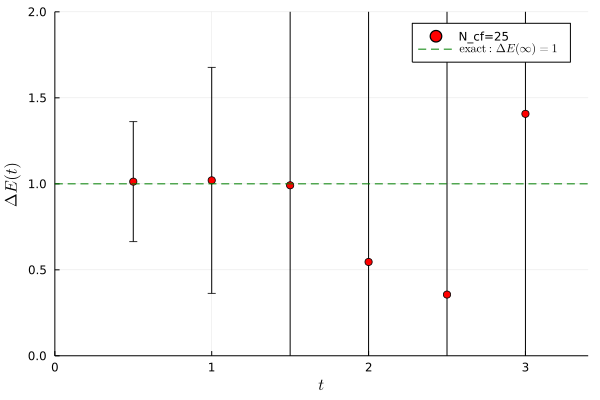

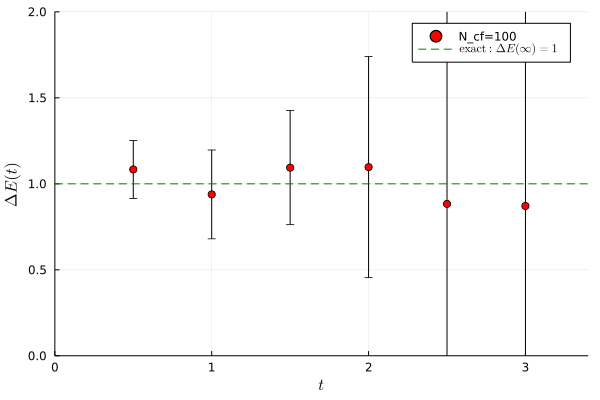

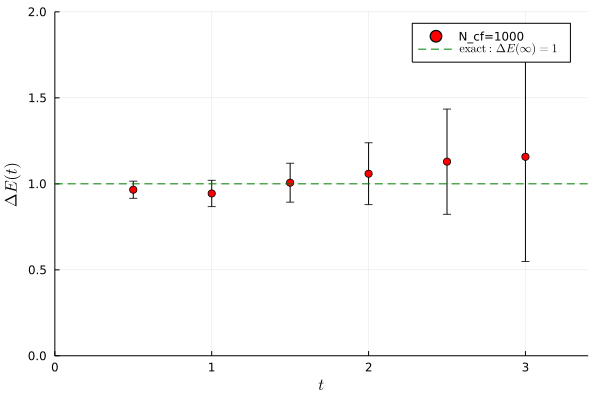

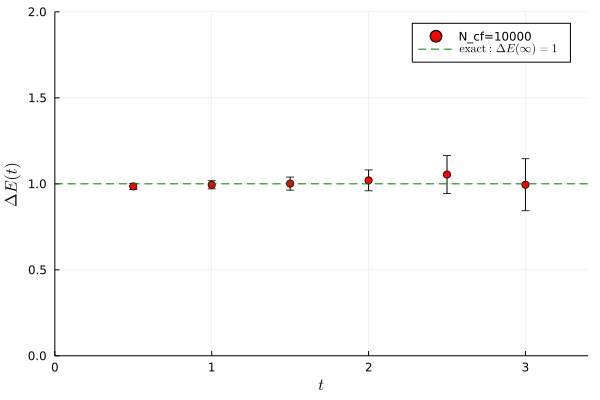

In [36]:
function exercise2()
    N_cfs = [25, 100, 1000, 10000] # Different config. lengths to try

    for N_cf in N_cfs
        a = 0.5
        N = 20
        ϵ = 1.4
        N_cor  = 20
        #N_cf = trunc(Int, 1e4)
        #binsize = 1 # This is really for a later exercise.
        action = ACTION_HO
        params = Params(a,ϵ,N,N_cor,N_cf, action)
        Gs = montecarlocalculation(params)
        #G_binned = zeros(N_cf÷binsize,N)
        #for n in 1:N
        #    G_binned[:,n] = bin(Gs[:,n],binsize)
        #end
        ΔEs = ΔE(Gs,params)[1:N÷2]
        sdΔE = bootstrap_ΔE(Gs,params)[1:N÷2]
        time = params.a*(1:length(ΔEs))

        p = plot(
            time, ΔEs, yerror=sdΔE,  seriestype=:scatter,color="red",xlims=(0,3.4),ylims=(0,2),
            label="N_cf="*string(N_cf), xlabel=L"t",ylabel=L"\Delta E(t)"
        )
        hline!([1],label=L"\mathrm{exact: }\Delta E(\infty)=1",color="green",linestyle=:dash)

        display(p)
    end
    
end
exercise2()

We can readily observe that increasing the size of $N_\text{cf}$ improves the precision of our resulting $\Delta E(t)$ calculation. Furthermore, this seems in reasonable agreement with Lepage's results, cf. Figure 4 on page 11.

I have some concern about the actualy accuracy of this calculation, as zooming in:

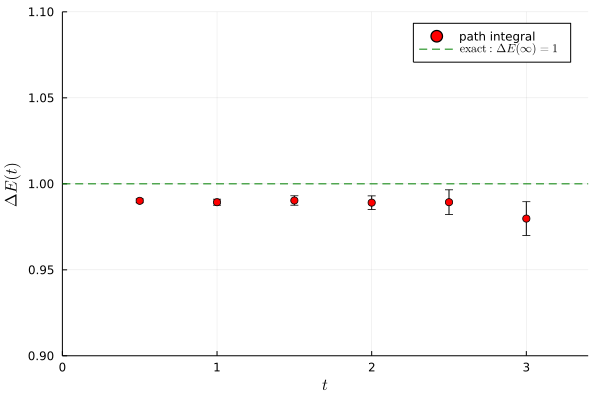

In [37]:
function exercise2zoomed()
    a = 0.5
    N = 50
    ϵ = 1.4
    N_cor  = 20
    N_cf = trunc(Int, 1e6)
    binsize = 200
    action = ACTION_HO
    params = Params(a,ϵ,N,N_cor,N_cf, action)
    Gs = montecarlocalculation(params)
    #println(Gs)
    G_binned = zeros(N_cf÷binsize,N)
    for (n,G_col) in enumerate(eachcol(Gs))
        G_binned[:,n] = bin(G_col,binsize)
    end
    #computeandwrite(params)
    #G_binned = readdata()
    ΔEs = ΔE(G_binned,params)[begin:N÷2]
    sdΔE = bootstrap_ΔE(G_binned,params)[begin:N÷2]
    time = params.a*(1:length(ΔEs))
    plot(
        time, ΔEs, yerror=sdΔE,  seriestype=:scatter,color="red",xlims=(0,3.4),ylims=(0.9,1.1),
        label="path integral", xlabel=L"t",ylabel=L"\Delta E(t)"
    )
    hline!([1],label=L"\mathrm{exact: }\Delta E(\infty)=1",color="green",linestyle=:dash)
    
    
end
exercise2zoomed()

Then we see that we clearly don't converge to the correct asymptotic value.

Exploring decreasing the lattice spacing,

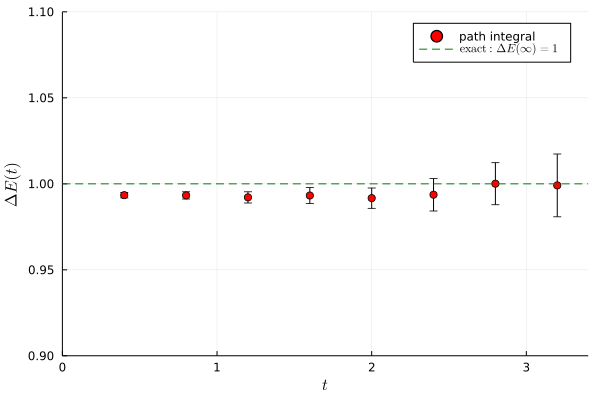

In [38]:
function exercise2zoomed()
    a = 0.4
    N = 50
    ϵ = 1.4
    N_cor  = 20
    N_cf = trunc(Int, 1e6)
    binsize = 200
    action = ACTION_HO
    params = Params(a,ϵ,N,N_cor,N_cf, action)
    Gs = montecarlocalculation(params)
    #println(Gs)
    G_binned = zeros(N_cf÷binsize,N)
    for (n,G_col) in enumerate(eachcol(Gs))
        G_binned[:,n] = bin(G_col,binsize)
    end
    #computeandwrite(params)
    #G_binned = readdata()
    ΔEs = ΔE(G_binned,params)[begin:N÷2]
    sdΔE = bootstrap_ΔE(G_binned,params)[begin:N÷2]
    time = params.a*(1:length(ΔEs))
    plot(
        time, ΔEs, yerror=sdΔE,  seriestype=:scatter,color="red",xlims=(0,3.4),ylims=(0.9,1.1),
        label="path integral", xlabel=L"t",ylabel=L"\Delta E(t)"
    )
    hline!([1],label=L"\mathrm{exact: }\Delta E(\infty)=1",color="green",linestyle=:dash)
    
    
end
exercise2zoomed()

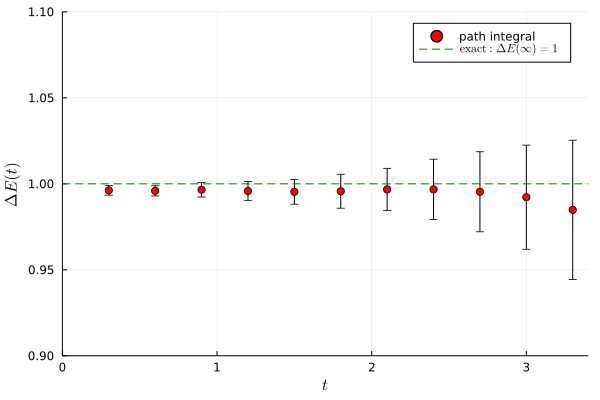

In [39]:
function exercise2zoomed()
    a = 0.3
    N = 50
    ϵ = 1.4
    N_cor  = 20
    N_cf = trunc(Int, 1e6)
    binsize = 200
    action = ACTION_HO
    params = Params(a,ϵ,N,N_cor,N_cf, action)
    Gs = montecarlocalculation(params)
    #println(Gs)
    G_binned = zeros(N_cf÷binsize,N)
    for (n,G_col) in enumerate(eachcol(Gs))
        G_binned[:,n] = bin(G_col,binsize)
    end
    #computeandwrite(params)
    #G_binned = readdata()
    ΔEs = ΔE(G_binned,params)[begin:N÷2]
    sdΔE = bootstrap_ΔE(G_binned,params)[begin:N÷2]
    time = params.a*(1:length(ΔEs))
    plot(
        time, ΔEs, yerror=sdΔE,  seriestype=:scatter,color="red",xlims=(0,3.4),ylims=(0.9,1.1),
        label="path integral", xlabel=L"t",ylabel=L"\Delta E(t)"
    )
    hline!([1],label=L"\mathrm{exact: }\Delta E(\infty)=1",color="green",linestyle=:dash)
    
    
end
exercise2zoomed()

does seem to improve the acurracy quite a bit; though, the precision is suffering.  I'd suspect that there is some systematic error that shifts the numerical value down then? No idea how to calculate that.

We can do the same calculation for an anharmonic potential:

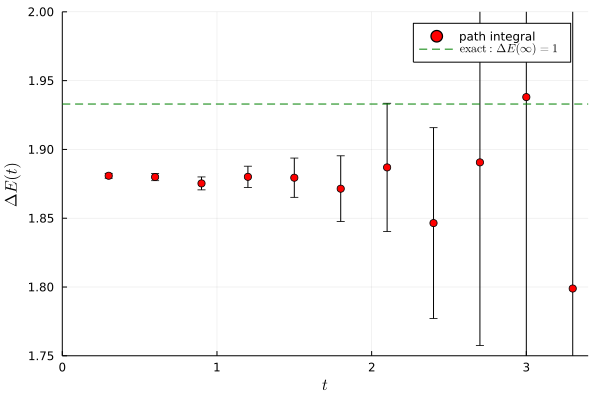

In [40]:
function exercise2anh()
    a = 0.3
    N = 50
    ϵ = 1.4
    N_cor  = 20
    N_cf = trunc(Int, 1e6)
    binsize = 200
    action = ACTION_AHO
    params = Params(a,ϵ,N,N_cor,N_cf, action)
    Gs = montecarlocalculation(params)
    #println(Gs)
    G_binned = zeros(N_cf÷binsize,N)
    for (n,G_col) in enumerate(eachcol(Gs))
        G_binned[:,n] = bin(G_col,binsize)
    end
    #computeandwrite(params)
    #G_binned = readdata()
    ΔEs = ΔE(G_binned,params)[begin:N÷2]
    sdΔE = bootstrap_ΔE(G_binned,params)[begin:N÷2]
    time = params.a*(1:length(ΔEs))
    plot(
        time, ΔEs, yerror=sdΔE,  seriestype=:scatter,color="red",xlims=(0,3.4),ylims=(1.75,2),
        label="path integral", xlabel=L"t",ylabel=L"\Delta E(t)"
    )
    hline!([1.933],label=L"\mathrm{exact: }\Delta E(\infty)=1",color="green",linestyle=:dash)
    
    
end
exercise2anh()

This is a fair bit off from where it should be, but let's see if it trends towards something more reasonable.

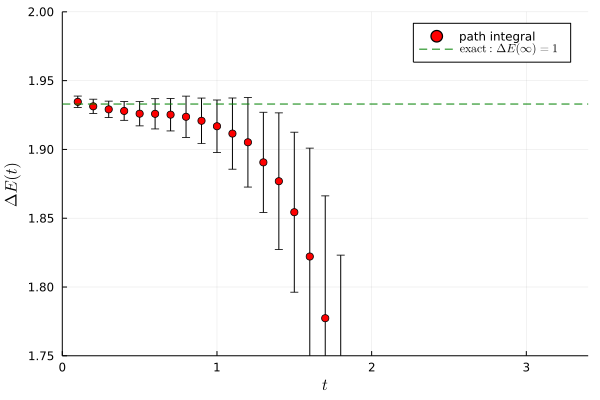

In [41]:
function exercise2anh()
    a = 0.1
    N = 50
    ϵ = 1.4
    N_cor  = 20
    N_cf = trunc(Int, 1e7)
    binsize = 200
    action = ACTION_AHO
    params = Params(a,ϵ,N,N_cor,N_cf, action)
    Gs = montecarlocalculation(params)
    #println(Gs)
    G_binned = zeros(N_cf÷binsize,N)
    for (n,G_col) in enumerate(eachcol(Gs))
        G_binned[:,n] = bin(G_col,binsize)
    end
    #computeandwrite(params)
    #G_binned = readdata()
    ΔEs = ΔE(G_binned,params)[begin:N÷2]
    sdΔE = bootstrap_ΔE(G_binned,params)[begin:N÷2]
    time = params.a*(1:length(ΔEs))
    plot(
        time, ΔEs, yerror=sdΔE,  seriestype=:scatter,color="red",xlims=(0,3.4),ylims=(1.75,2),
        label="path integral", xlabel=L"t",ylabel=L"\Delta E(t)"
    )
    hline!([1.933],label=L"\mathrm{exact: }\Delta E(\infty)=1",color="green",linestyle=:dash)
    
    
end
exercise2anh() #This takes like eight minutes, so don't run it again

This keeps crashing the kernel for some reason. It used to work fine as seen in the git repo.

Well, I plotted too much of the data, but it does look like it might be somewhat reasonable afterall.  TODO: Maybe run this again with better plotting range.

## Exercise 3

Redo the previous exercise but propagator

$$ G(t) = \frac{1}{N}\sum_{j}\langle\langle x^3(t_j+t)x^3(t_j) \rangle\rangle.$$

Here we use $x^3$ rather than $x$ to create and destroy the excited stated; that is, we use $x^3$ rather than $x$ as the "source" and "sink." Note that $\Delta E(t)$ converges to the same result, but only at much larger $t$'s than before. Different sources and sinks often lead to different asymtotic behaviour. Choices that result in fast convergences as $t$ increases are usually prefereable because statistical errors are smaller at smaller $t$'s. Compare your best estimate of the asymptotic value obtained used $x^3$ with that obatined using $x$.

Note also that $\Delta E(t)$ approaches its asymptotic value from above. Prove that this must be true in general, provided source and sink are the same operator, using Eq. (23). This result is useful because it implies that each $\Delta E(t)$ gives a rigorous upper bound on the asymptotic value, even at small $t's$ before convergence.

## Solution:

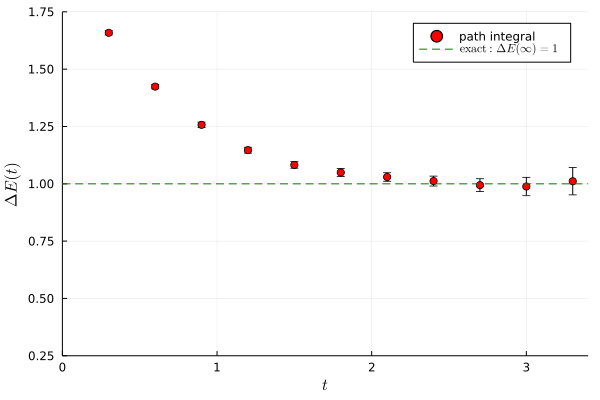

In [42]:
function exercise3zoomed()
    a = 0.3
    N = 50
    ϵ = 1.4
    N_cor  = 20
    N_cf = trunc(Int, 1e6)
    binsize = 200
    action = ACTION_HO
    params = Params(a,ϵ,N,N_cor,N_cf, action)
    Gs = montecarlocalculation3(params)
    #println(Gs)
    G_binned = zeros(N_cf÷binsize,N)
    for (n,G_col) in enumerate(eachcol(Gs))
        G_binned[:,n] = bin(G_col,binsize)
    end
    #computeandwrite(params)
    #G_binned = readdata()
    ΔEs = ΔE(G_binned,params)[begin:N÷2]
    sdΔE = bootstrap_ΔE(G_binned,params)[begin:N÷2]
    time = params.a*(1:length(ΔEs))
    plot(
        time, ΔEs, yerror=sdΔE,  seriestype=:scatter,color="red",xlims=(0,3.4),ylims=(.25,1.75),
        label="path integral", xlabel=L"t",ylabel=L"\Delta E(t)"
    )
    hline!([1],label=L"\mathrm{exact: }\Delta E(\infty)=1",color="green",linestyle=:dash)
    
    
end
exercise3zoomed()

This does seem to converge to the right value; though, quite slowly and indeed from above.

## Exercise 4:

Rerun your Metropolis simulation of the harmonic oscillator with $N_\text{cor}=1$. Do several different runs and compare your results. Do they agree within statistical errors? Try binning the results from each of the runs in bins of 20 and recompute the statistical errors. Verify that different runs now agree within the errors computed from the binned results.

## Solution:

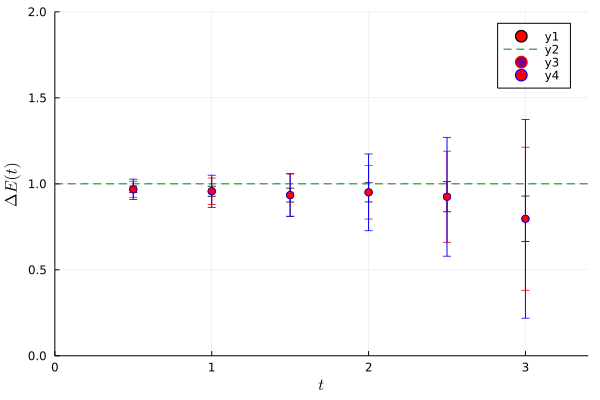

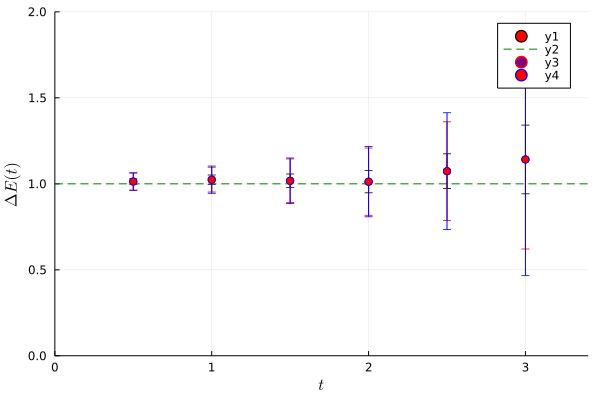

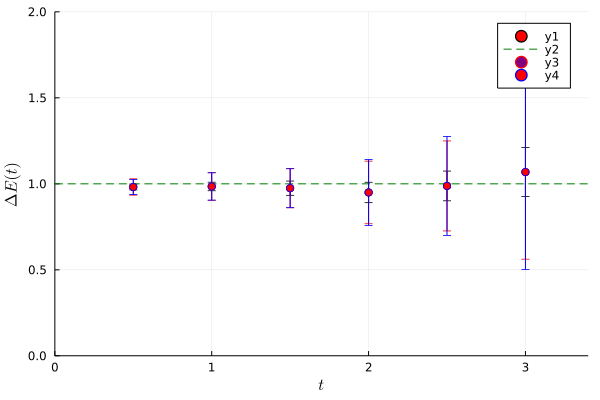

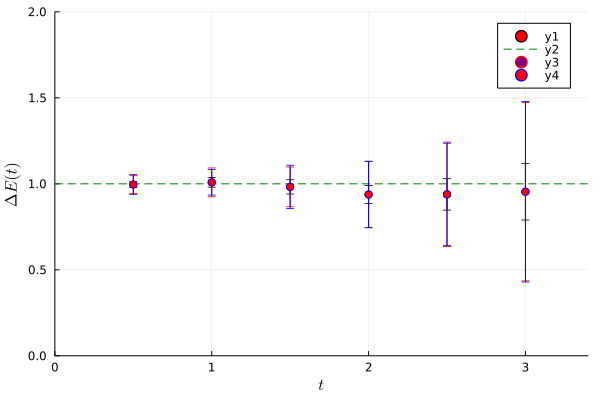

In [43]:
function exercise4()

    for _ in 1:4
        a = 0.5
        N = 20
        ϵ = 1.4
        N_cor  = 1
        N_cf = trunc(Int, 1e4)
        #binsize = 1 # This is really for a later exercise.
        action = ACTION_HO
        params = Params(a,ϵ,N,N_cor,N_cf, action)
        Gs = montecarlocalculation(params)
        #G_binned = zeros(N_cf÷binsize,N)
        #for n in 1:N
        #    G_binned[:,n] = bin(Gs[:,n],binsize)
        #end
        ΔEs = ΔE(Gs,params)[1:N÷2]
        sdΔE = bootstrap_ΔE(Gs,params)[1:N÷2]
        time = params.a*(1:length(ΔEs))

        p = plot(
            time, ΔEs, yerror=sdΔE,  seriestype=:scatter,color="red",xlims=(0,3.4),ylims=(0,2),
            xlabel=L"t",ylabel=L"\Delta E(t)"
        )
        hline!([1],color="green",linestyle=:dash)

        binsize = 20
        G_binned = zeros(N_cf÷binsize,N)
        for n in 1:N
            G_binned[:,n] = bin(Gs[:,n],binsize)
        end
        ΔEs = ΔE(G_binned,params)[1:N÷2]
        sdΔE = bootstrap_ΔE(G_binned,params)[1:N÷2]
        time = params.a*(1:length(ΔEs))

        plot!(
            time, ΔEs, yerror=sdΔE,  seriestype=:scatter,color="purple",xlims=(0,3.4),ylims=(0,2),
            xlabel=L"t",ylabel=L"\Delta E(t)",msc=:red
        )

        binsize = 40
        G_binned = zeros(N_cf÷binsize,N)
        for n in 1:N
            G_binned[:,n] = bin(Gs[:,n],binsize)
        end
        ΔEs = ΔE(G_binned,params)[1:N÷2]
        sdΔE = bootstrap_ΔE(G_binned,params)[1:N÷2]
        time = params.a*(1:length(ΔEs))

        plot!(
            time, ΔEs, yerror=sdΔE,  seriestype=:scatter,color="red",xlims=(0,3.4),ylims=(0,2),
            xlabel=L"t",ylabel=L"\Delta E(t)",msc=:blue
        )

        display(p)
    end
    
end
exercise4()

We can observe that over multiple runs the values are only sometimes accurate within statistical error. But, by binning every 20, the error bars grow substantially, indicating that the data was correlated.  Post binning, the values now all agree within statistical errors.  And, by doubling the binsize, we don't see significant growth in the statistical errors, indicating the data is no longer (as?) correlated. The plot colouring also look disgusting; woops.  The smallest error bars (black) are the unbinned data, the red is binned with binsize=20, and the blue with binsize=40.

## Exercise 5:

Our action for one-dimensional quantum mechanics, Eq. (4), can be rewritten

$$ S[x] = \int_{t_i}^{t_f}dt\big[ -\frac{1}{2}mx(t)\ddot{x}(t) + V(x(t)) \big],$$

by integating by parts (assuming $x(t_i)=x(t_f)=x$) (!*). To discretize we replace

$$ \ddot{x}(t_j) \to \Delta^{(2)}x_j \coloneqq \frac{x_{j+1}-2x_j + x_{j-1}}{a^2},$$

where the $x_j$'s are periodic ($x_0=x_N$, $x_{-1}=x_{N-1}$, and so on); this gives the same lattice action we used earlier (!**). We can improve the discretization, however, by using the corrected approximation, Eq. (50), for the second derivative:

$$ S_\text{imp}[x] \coloneqq \sum_{j=0}^{N-1}a\big( -\frac{1}{2}mx_j( \Delta^{(2)}-a(\Delta^{(2)})^2/12 )x_j + aV(x_j) \big). $$

[ I think there is a typo of an extra $a$ ?]

Modify your Monte Carlo code for the harmonic oscillator to include the correction term. Run high-statistics comparisons ($N_\text{cf}=10^4$ or $10^5$) with and without correction term.

### Check (*)

Recall Eq. (4):

$$ S[x] = \int_{t_i}^{t_f}dt \big( \frac{m \dot{x}(t)}{2} + V(x(t)) \big).$$

Letting 

$$ u = \dot{x}, \quad dv = \dot{x}dt,$$

and so

$$ du = \ddot{x}dt,\quad v = x.$$

Therefore,

$$ \int_{t_i}^{t_f}dt \dot{x}(t)\dot{x}(t) = x(t)\dot{x}(t)|_{t_i}^{t_f} - \int_{t_i}^{t_f}dt x(t)\ddot{x}(t) = - \int_{t_i}^{t_f}dt x(t)\ddot{x}(t),$$

where the boundary terms vanish from the periodicity assumption ($x(t_i)=x(t_f)=x$).

### Check (**)

TODO



## Solution:

In [44]:
function exercise5()

    a = 0.5
    N = 50
    ϵ = 1.4
    N_cor  = 1
    N_cf = trunc(Int, 1e6)
    binsize = 50 # This is really for a later exercise.
    action = ACTION_HO
    params = Params(a,ϵ,N,N_cor,N_cf, action)
    Gs = montecarlocalculation(params)
    G_binned = zeros(N_cf÷binsize,N)
    for n in 1:N
        G_binned[:,n] = bin(Gs[:,n],binsize)
    end
    ΔEs = ΔE(G_binned,params)[1:N÷2]
    sdΔE = bootstrap_ΔE(G_binned,params)[1:N÷2]
    time = params.a*(1:length(ΔEs))

    p = plot(
        time, ΔEs, yerror=sdΔE,  seriestype=:scatter,color="red",xlims=(0,3.4),ylims=(0,2),
        xlabel=L"t",ylabel=L"\Delta E(t)",label="Unimproved"
    )
    hline!([1],color="green",linestyle=:dash,label=L"\mathrm{exact: }\Delta E(\infty)=1")

    action = ACTION_HO_IMPROVED
    params = Params(a,ϵ,N,N_cor,N_cf, action)
    Gs = montecarlocalculation(params)
    G_binned = zeros(N_cf÷binsize,N)
    for n in 1:N
        G_binned[:,n] = bin(Gs[:,n],binsize)
    end
    ΔEs = ΔE(G_binned,params)[1:N÷2]
    sdΔE = bootstrap_ΔE(G_binned,params)[1:N÷2]
    time = params.a*(1:length(ΔEs))

    plot!(
        time, ΔEs, yerror=sdΔE,  seriestype=:scatter,color="purple",xlims=(0,3.4),ylims=(0.5,1.5),
        xlabel=L"t",ylabel=L"\Delta E(t)",label="Improved"
    )

    display(p)
end
exercise5()

We can see that the energies do approach their asymptotic value from below with the improved action, while converging to a similar value as the unimproved.

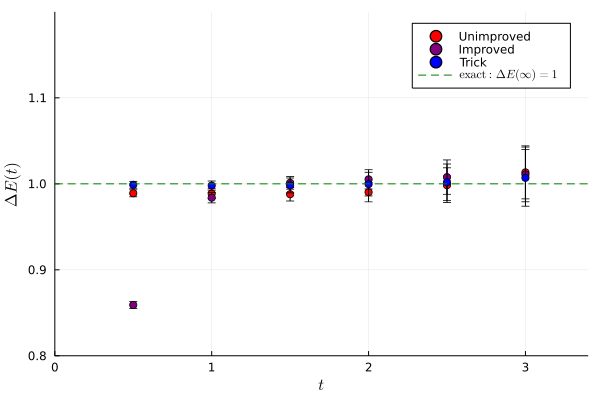

In [45]:
function exercise6()

    a = 0.5
    N = 50
    ϵ = 1.4
    N_cor  = 1
    N_cf = trunc(Int, 1e6)
    binsize = 50 # This is really for a later exercise.
    action = ACTION_HO
    params = Params(a,ϵ,N,N_cor,N_cf, action)
    Gs = montecarlocalculation(params)
    G_binned = zeros(N_cf÷binsize,N)
    for n in 1:N
        G_binned[:,n] = bin(Gs[:,n],binsize)
    end
    ΔEs = ΔE(G_binned,params)[1:N÷2]
    sdΔE = bootstrap_ΔE(G_binned,params)[1:N÷2]
    time = params.a*(1:length(ΔEs))

    p = plot(
        time, ΔEs, yerror=sdΔE,  seriestype=:scatter,color="red",xlims=(0,3.4),ylims=(0.8,1.2),
        xlabel=L"t",ylabel=L"\Delta E(t)",label="Unimproved"
    )

    action = ACTION_HO_IMPROVED
    params = Params(a,ϵ,N,N_cor,N_cf, action)
    Gs = montecarlocalculation(params)
    G_binned = zeros(N_cf÷binsize,N)
    for n in 1:N
        G_binned[:,n] = bin(Gs[:,n],binsize)
    end
    ΔEs = ΔE(G_binned,params)[1:N÷2]
    sdΔE = bootstrap_ΔE(G_binned,params)[1:N÷2]
    time = params.a*(1:length(ΔEs))

    plot!(
        time, ΔEs, yerror=sdΔE,  seriestype=:scatter,color="purple",xlims=(0,3.4),ylims=(0.8,1.2),
        xlabel=L"t",ylabel=L"\Delta E(t)",label="Improved"
    )

    action = ACTION_HO_TRICK
    params = Params(a,ϵ,N,N_cor,N_cf, action)
    Gs = montecarlocalculation(params)
    G_binned = zeros(N_cf÷binsize,N)
    for n in 1:N
        G_binned[:,n] = bin(Gs[:,n],binsize)
    end
    ΔEs = ΔE(G_binned,params)[1:N÷2]
    sdΔE = bootstrap_ΔE(G_binned,params)[1:N÷2]
    time = params.a*(1:length(ΔEs))

    plot!(
        time, ΔEs, yerror=sdΔE,  seriestype=:scatter,color="blue",xlims=(0,3.4),ylims=(0.8,1.2),
        xlabel=L"t",ylabel=L"\Delta E(t)",label="Trick"
    )
    
    hline!([1],color="green",linestyle=:dash,label=L"\mathrm{exact: }\Delta E(\infty)=1")

    display(p)
end
exercise6()

Using the field transformation trick, we see that the values of $\Delta E(t)$ are far more accurate and converge quicker that the improved.

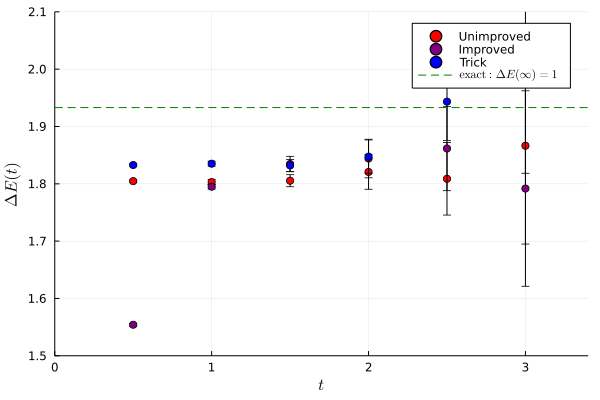

In [46]:
function exercise7()

    a = 0.5
    N = 50
    ϵ = 1.4
    N_cor  = 1
    N_cf = trunc(Int, 1e6)
    binsize = 50 # This is really for a later exercise.
    action = ACTION_AHO
    params = Params(a,ϵ,N,N_cor,N_cf, action)
    Gs = montecarlocalculation(params)
    G_binned = zeros(N_cf÷binsize,N)
    for n in 1:N
        G_binned[:,n] = bin(Gs[:,n],binsize)
    end
    ΔEs = ΔE(G_binned,params)[1:N÷2]
    sdΔE = bootstrap_ΔE(G_binned,params)[1:N÷2]
    time = params.a*(1:length(ΔEs))

    p = plot(
        time, ΔEs, yerror=sdΔE,  seriestype=:scatter,color="red",xlims=(0,3.4),ylims=(1.5,2.1),
        xlabel=L"t",ylabel=L"\Delta E(t)",label="Unimproved"
    )

    action = ACTION_AHO_IMPROVED
    params = Params(a,ϵ,N,N_cor,N_cf, action)
    Gs = montecarlocalculation(params)
    G_binned = zeros(N_cf÷binsize,N)
    for n in 1:N
        G_binned[:,n] = bin(Gs[:,n],binsize)
    end
    ΔEs = ΔE(G_binned,params)[1:N÷2]
    sdΔE = bootstrap_ΔE(G_binned,params)[1:N÷2]
    time = params.a*(1:length(ΔEs))

    plot!(
        time, ΔEs, yerror=sdΔE,  seriestype=:scatter,color="purple",
        xlabel=L"t",ylabel=L"\Delta E(t)",label="Improved"
    )

    action = ACTION_AHO_TRICK
    params = Params(a,ϵ,N,N_cor,N_cf, action)
    Gs = montecarlocalculation(params)
    G_binned = zeros(N_cf÷binsize,N)
    for n in 1:N
        G_binned[:,n] = bin(Gs[:,n],binsize)
    end
    ΔEs = ΔE(G_binned,params)[1:N÷2]
    sdΔE = bootstrap_ΔE(G_binned,params)[1:N÷2]
    time = params.a*(1:length(ΔEs))

    plot!(
        time, ΔEs, yerror=sdΔE,  seriestype=:scatter,color="blue",xlims=(0,3.4),
        xlabel=L"t",ylabel=L"\Delta E(t)",label="Trick"
    )
    
    hline!([1.933],color="green",linestyle=:dash,label=L"\mathrm{exact: }\Delta E(\infty)=1")

    display(p)
end
exercise7()

This doesn't seem as good as before, but it does seem to follow the convergence speed of the unimproved while being more accurate like the improved action.

### The rest is not just messing around; TODO clean up/remove

In [47]:
function test(x,y,σ)
    sum = 0.0;
    for j in 1:length(x)
        sum += ((y[j] - x[j])/σ[j])^2
    end
    return sum/(length(x)-1)
    end

test (generic function with 1 method)

0.1847533318145438


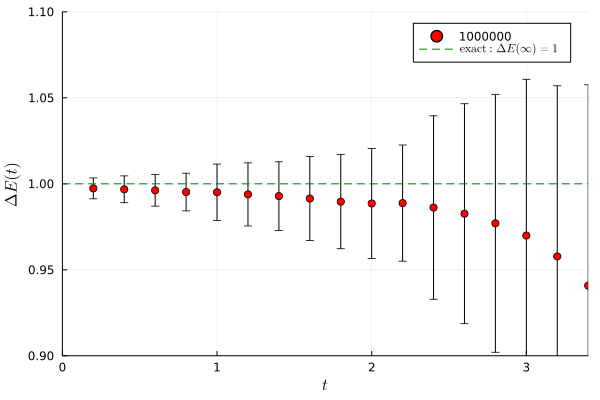

In [48]:
function exercise2a()
    a = 0.2
    N = 50
    ϵ = 1.4
    N_cor  = 20
    N_cf = trunc(Int, 1e6)
    binsize = 200 # This is really for a later exercise.
    action = ACTION_HO
    params = Params(a,ϵ,N,N_cor,N_cf, action)
    Gs = montecarlocalculation(params)
    G_binned = zeros(N_cf÷binsize,N)
    for n in 1:N
        G_binned[:,n] = bin(Gs[:,n],binsize)
    end
    ΔEs = ΔE(G_binned,params)[1:N÷2]
    sdΔE = bootstrap_ΔE(G_binned,params)[1:N÷2]
    time = params.a*(1:length(ΔEs))
    println(test(ΔEs[1:6],ones(6),sdΔE[1:6]))
    plot(
        time, ΔEs, yerror=sdΔE,  seriestype=:scatter,color="red",xlims=(0,3.4),ylims=(.9,1.1),
        label=string(N_cf), xlabel=L"t",ylabel=L"\Delta E(t)"
    )
    hline!([1],label=L"\mathrm{exact: }\Delta E(\infty)=1",color="green",linestyle=:dash)
    
end
exercise2a()

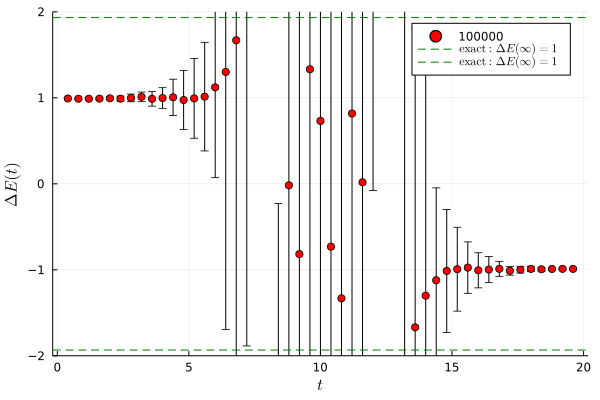

In [49]:
function exercise2a()
    a = 0.4
    N = 50
    ϵ = 1.4
    N_cor  = 20
    N_cf = trunc(Int, 1e5)
    binsize = 200 # This is really for a later exercise.
    action = ACTION_HO
    params = Params(a,ϵ,N,N_cor,N_cf, action)
    Gs = montecarlocalculation(params)
    G_binned = zeros(N_cf÷binsize,N)
    for n in 1:N
        G_binned[:,n] = bin(Gs[:,n],binsize)
    end
    ΔEs = ΔE(G_binned,params)#[1:N÷2]
    sdΔE = bootstrap_ΔE(G_binned,params)#[1:N÷2]
    time = params.a*(1:length(ΔEs))

    plot(
        time, ΔEs, yerror=sdΔE,  seriestype=:scatter,color="red",ylims=(-2,2),#xlims=(0,3.4),ylims=(1.8,2.2),
        label=string(N_cf), xlabel=L"t",ylabel=L"\Delta E(t)"
    )
    hline!([1.933],label=L"\mathrm{exact: }\Delta E(\infty)=1",color="green",linestyle=:dash)
    hline!([-1.933],label=L"\mathrm{exact: }\Delta E(\infty)=1",color="green",linestyle=:dash)

end
exercise2a()

In [50]:
using OffsetArrays

ArgumentError: ArgumentError: Package OffsetArrays not found in current path:
- Run `import Pkg; Pkg.add("OffsetArrays")` to install the OffsetArrays package.


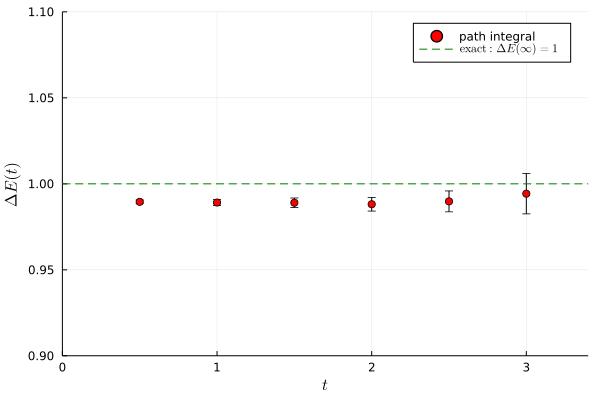

In [51]:
function main()
    a = 0.5
    N = 50
    ϵ = 1.4
    N_cor  = 20
    N_cf = trunc(Int, 1e6)
    binsize = 200
    action = ACTION_HO
    params = Params(a,ϵ,N,N_cor,N_cf, action)
    Gs = montecarlocalculation(params)
    #println(Gs)
    G_binned = zeros(N_cf÷binsize,N)
    for (n,G_col) in enumerate(eachcol(Gs))
        G_binned[:,n] = bin(G_col,binsize)
    end
    #computeandwrite(params)
    #G_binned = readdata()
    ΔEs = ΔE(G_binned,params)[begin:N÷2]
    sdΔE = bootstrap_ΔE(G_binned,params)[begin:N÷2]
    time = params.a*(1:length(ΔEs))
    plot(
        time, ΔEs, yerror=sdΔE,  seriestype=:scatter,color="red",xlims=(0,3.4),ylims=(0.9,1.1),
        label="path integral", xlabel=L"t",ylabel=L"\Delta E(t)"
    )
    hline!([1],label=L"\mathrm{exact: }\Delta E(\infty)=1",color="green",linestyle=:dash)
    
    
end
main()

In [52]:
function main()
    a = 0.5
    N = 20
    ϵ = 1.4
    N_cor  = 20
    N_cf = trunc(Int, 1e4)
    binsize = 200
    action = ACTION_HO_IMPROVED
    params = Params(a,ϵ,N,N_cor,N_cf, action)
    Gs = montecarlocalculation(params)
    G_binned = zeros(N_cf÷binsize,N)
    for n in 1:N
        G_binned[:,n] = bin(Gs[:,n],binsize)
    end
    ΔEs = ΔE(G_binned,params)
    sdΔE = bootstrap_ΔE(G_binned,params)
    time = params.a*(1:length(ΔEs))
    plot(
        time, ΔEs, yerror=sdΔE,  seriestype=:scatter,color="red",
        label="path integral", xlabel=L"t",ylabel=L"\Delta E(t)"
    )
    hline!([1],label=L"\mathrm{exact: }\Delta E(\infty)=1",color="green",linestyle=:dash)
    
    
end
main()